In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
%matplotlib inline

In [4]:
!ls ../data

data.csv


In [5]:
df = pd.read_csv("../data/data.csv", encoding = "ISO-8859-1")

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.shape

(541909, 8)

In [9]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
df.shape

(406829, 8)

In [10]:
df.duplicated().sum()

5225

In [11]:
df.drop_duplicates(inplace = True)
df.shape

(401604, 8)

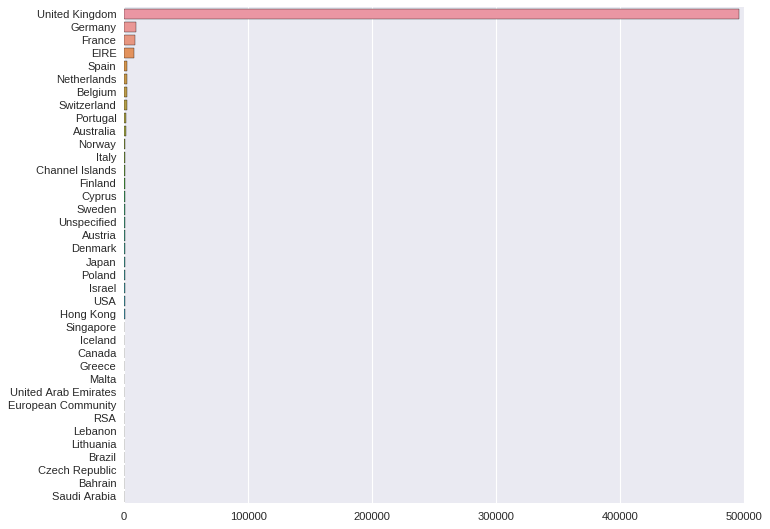

In [38]:
country_counts = df['Country'].value_counts()
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.barplot(list(country_counts), list(country_counts.index))

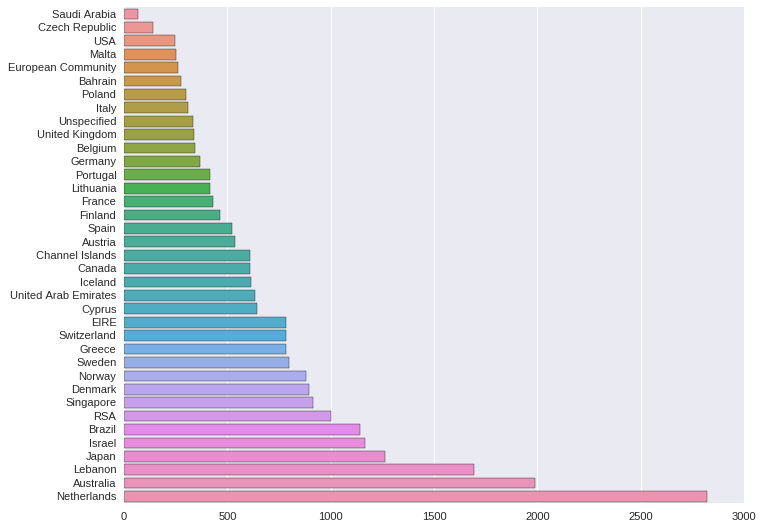

In [52]:
df["Price"] = df["UnitPrice"] * df["Quantity"]
best_buyer = df.groupby(["Country", "InvoiceNo"])["Price"].sum().reset_index().groupby(["Country"])["Price"].mean().sort_values()

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.barplot(list(best_buyer), list(best_buyer.index))

In [14]:
pd.DataFrame([{'products':     len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers':    len(df['CustomerID'].value_counts())}], 
            columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [16]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


In [18]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


In [21]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID']  == col['CustomerID']) &
                 (df['StockCode']   == col['StockCode'])  & 
                 (df['InvoiceDate'] < col['InvoiceDate']) & 
                 (df['Quantity']    > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [22]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 2607


In [23]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

In [24]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,74215,0.0
72254,542237,22726,ALARM CLOCK BAKELIKE GREEN,4,1/26/2011 14:30,3.75,12347.0,Iceland,0,15.0
14947,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,12347.0,Iceland,0,15.0
14948,537626,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,12/7/2010 14:57,3.75,12347.0,Iceland,0,15.0
14949,537626,22726,ALARM CLOCK BAKELIKE GREEN,4,12/7/2010 14:57,3.75,12347.0,Iceland,0,15.0


In [33]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [34]:
df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})

In [39]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Nb of keywords in variable 'Description': 1482


In [40]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

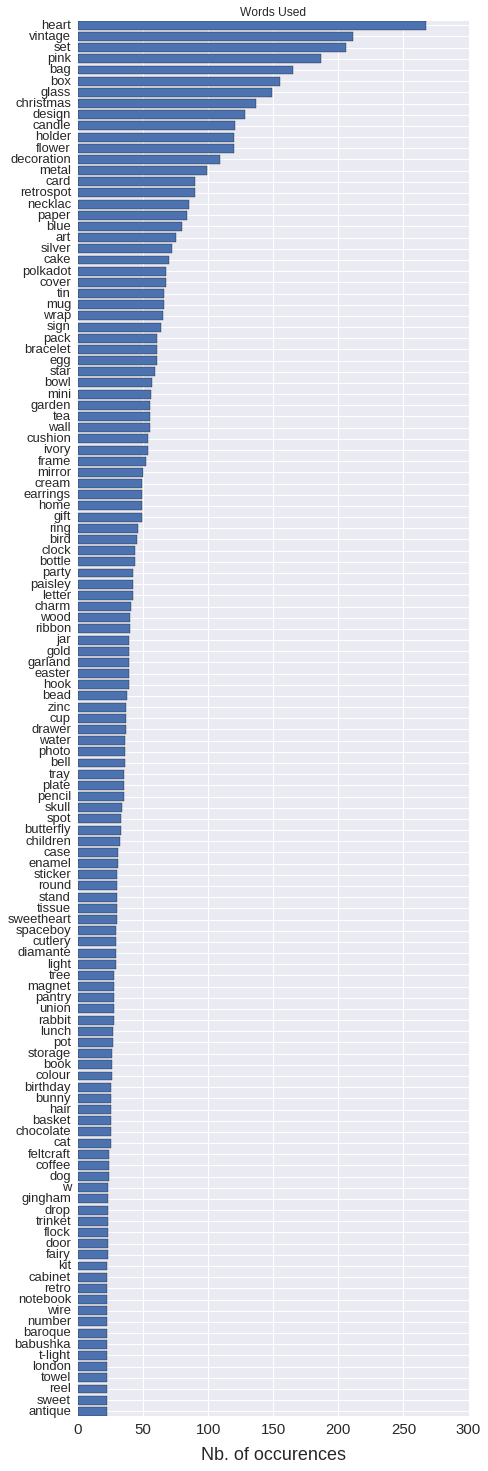

In [45]:
list1 = sorted(list_products, key = lambda x:x[1], reverse = True)


plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list1[:125]]
x_axis = [k for k,i in enumerate(list1[:125])]
x_label = [i[0] for i in list1[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words Used")
plt.show()

In [46]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

    
list_products.sort(key = lambda x:x[1], reverse = True)
